# POM ACO Network Evaluation and Optimization

Our project focuses on analyzing the POM ACO's provider networks across Michigan, examining the composition and performance of these networks over time. Through this analysis, we aim to uncover insights that can guide strategic decisions to optimize the network, ultimately improving performance against Medicare's mandated metrics.

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

## EDA

In [2]:
df1 = pd.read_excel('SOI_dataset.xlsx',sheet_name='TIN_Q1-5_TIN_Info')
df2 = pd.read_excel('SOI_dataset.xlsx',sheet_name='TIN_Q7,8-Total_Cost_EnrollType')
df3 = pd.read_excel('SOI_dataset.xlsx',sheet_name='TIN_Q9_TotalCost_By_Categories')
df4 = pd.read_excel('SOI_dataset.xlsx',sheet_name='TIN_Q10-13_Event_Rate')
df5 = pd.read_excel('SOI_dataset.xlsx',sheet_name='TIN_VISIT_Q8-14')

#### TIN_Q1-5_TIN_Info

In [3]:
df1.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE,BENE_CNT,AVR_RISK_SCORE
0,2019,OWTS,230982,ESRD,<11,4.244
1,2023,SDRU,636998,Disabled,<11,3.635
2,2023,OWTS,254468,Aged-Dual,<11,3.535
3,2022,OWTS,659770,ESRD,<11,3.239
4,2020,NTVP,592226,ESRD,<11,3.140


In [4]:
df1.size

6810

In [5]:
df1.isnull().sum()

PERFORMANCE_YEAR     0
QRO                  0
TIN_CCN              0
ENROLLMENT_TYPE      0
BENE_CNT             0
AVR_RISK_SCORE      22
dtype: int64

In [6]:
df1 = df1.fillna(0)

In [7]:
df1.QRO.unique()

array(['OWTS', 'SDRU', 'NTVP', 'MKLO', 'MTIP', 'UPLN'], dtype=object)

In [8]:
average_risk_by_qro = df1.groupby('QRO')['AVR_RISK_SCORE'].mean().reset_index()
average_risk_by_qro.sort_values('AVR_RISK_SCORE',ascending=False,inplace=True)
average_risk_by_qro

,QRO,AVR_RISK_SCORE
5,UPLN,1.194833
0,MKLO,1.182500
3,OWTS,1.010912
4,SDRU,0.898075
2,NTVP,0.896876
1,MTIP,0.760374


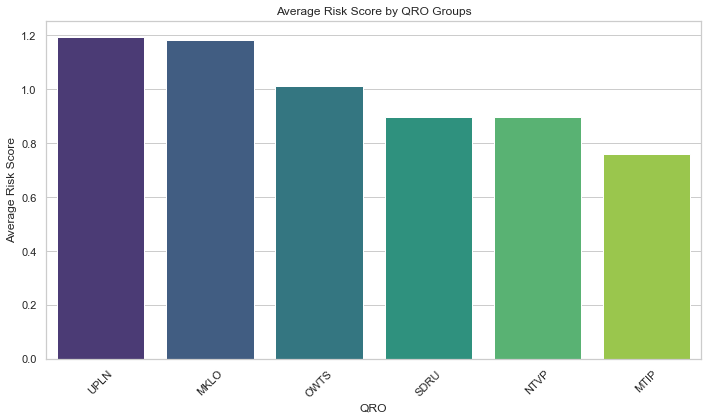

In [9]:
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(x='QRO',y='AVR_RISK_SCORE',data=average_risk_by_qro,palette='viridis')
plt.xlabel('QRO')
plt.ylabel('Average Risk Score')
plt.title('Average Risk Score by QRO Groups')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

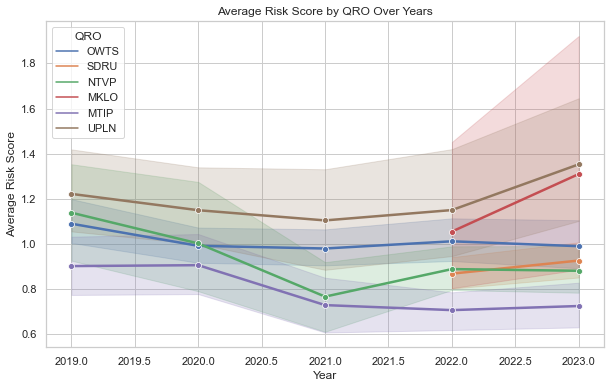

In [10]:
plt.figure(figsize=(10,6))
sns.lineplot(x='PERFORMANCE_YEAR',y='AVR_RISK_SCORE',data=df1,hue='QRO',marker='o',linewidth=2.5)
plt.title('Average Risk Score by QRO Over Years')
plt.xlabel('Year')
plt.ylabel('Average Risk Score')
plt.legend(title='QRO',loc='upper left')
plt.show()

In [11]:
df1[df1.QRO == 'UPLN']['ENROLLMENT_TYPE'].value_counts()

Aged-Dual    5
ESRD         5
Disabled     5
Aged         5
Unknown      4
Name: ENROLLMENT_TYPE, dtype: int64

UPLN receives more medically complex patients

#### TIN_Q7,8-Total_Cost_EnrollType

In [12]:
df2[df2.QRO == 'UPLN']

,PERFORMANCE_YEAR,QRO,TIN_CCN,TOTAL_SPEND,AGED_TOTAL_SPEND,DISABLED_TOTAL_SPEND,ESRD_TOTAL_ESRD,AGED_DUAL_TOTAL_SPEND
36,2019,UPLN,430950,2.399395e+08,1.629968e+08,41620297.54,18547627.79,16774793.22
78,2020,UPLN,430950,2.766308e+08,1.872492e+08,49279710.30,21949611.05,17201389.23
150,2021,UPLN,430950,3.111588e+08,2.151866e+08,54208480.34,19303294.13,19881386.70
262,2022,UPLN,430950,3.066105e+08,2.252036e+08,48224036.37,14761520.83,17764948.79
374,2023,UPLN,430950,2.772460e+08,2.112942e+08,37610732.92,12439351.48,14913897.84


In [13]:
df2.isnull().sum()

PERFORMANCE_YEAR           0
QRO                        0
TIN_CCN                    0
TOTAL_SPEND                0
AGED_TOTAL_SPEND          23
DISABLED_TOTAL_SPEND      48
ESRD_TOTAL_ESRD          230
AGED_DUAL_TOTAL_SPEND    103
dtype: int64

In [14]:
df2=df2.fillna(0)

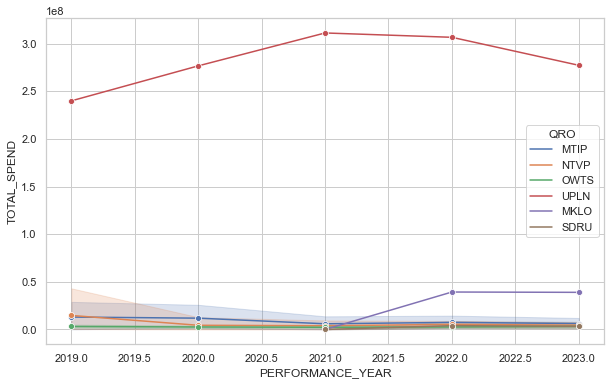

In [15]:
plt.figure(figsize=(10,6))
sns.lineplot(x='PERFORMANCE_YEAR',y='TOTAL_SPEND',data=df2,hue='QRO',marker='o')
plt.show()

In [16]:
df2_melted = df2.melt(id_vars=['PERFORMANCE_YEAR','QRO','TIN_CCN'],
                      value_vars=['AGED_TOTAL_SPEND', 'DISABLED_TOTAL_SPEND', 'ESRD_TOTAL_ESRD','AGED_DUAL_TOTAL_SPEND'],
                      var_name='SPEND_TYPE',
                      value_name='TOTAL_SPEND')
df2_melted

<ipython-input-16-6f9dcdd2bbc6>:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df2_melted = df2.melt(id_vars=['PERFORMANCE_YEAR','QRO','TIN_CCN'],


,PERFORMANCE_YEAR,QRO,TIN_CCN,SPEND_TYPE,TOTAL_SPEND
0,2019,MTIP,122406,AGED_TOTAL_SPEND,1755.58
1,2019,MTIP,679036,AGED_TOTAL_SPEND,122.30
2,2019,MTIP,344888,AGED_TOTAL_SPEND,0.00
3,2019,MTIP,125904,AGED_TOTAL_SPEND,165138.70
4,2019,MTIP,183834,AGED_TOTAL_SPEND,36549230.25
...,...,...,...,...,...
1495,2023,SDRU,877376,AGED_DUAL_TOTAL_SPEND,132900.31
1496,2023,SDRU,556858,AGED_DUAL_TOTAL_SPEND,173373.23
1497,2023,SDRU,676890,AGED_DUAL_TOTAL_SPEND,241529.24
1498,2023,SDRU,680049,AGED_DUAL_TOTAL_SPEND,1885.46


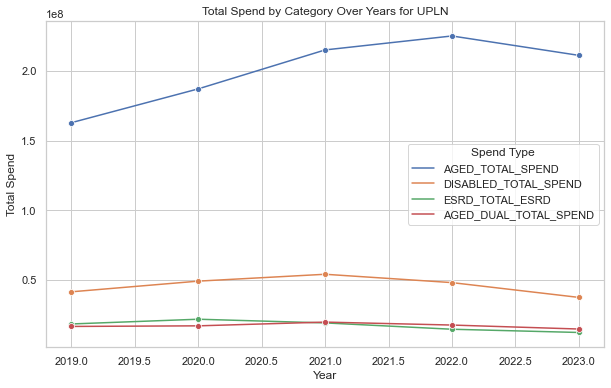

In [17]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df2_melted[df2_melted.QRO=='UPLN'],x='PERFORMANCE_YEAR',y='TOTAL_SPEND',hue='SPEND_TYPE',marker = 'o')
plt.title('Total Spend by Category Over Years for UPLN')
plt.xlabel('Year')
plt.ylabel('Total Spend')
plt.legend(title='Spend Type')
plt.show()

#### TIN_Q9_TotalCost_By_Categories


In [18]:
df3.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND
0,2019,MTIP,183834,19192504.70,16020228.69,9062788.08,4477877.38,1320060.30,1349982.92
1,2019,MTIP,834843,5364179.15,4602899.62,3152931.99,1253099.57,433572.46,548635.03
2,2019,MTIP,122406,NaN,11329.40,7003.38,NaN,NaN,NaN
3,2019,MTIP,344888,NaN,8.79,0.00,NaN,NaN,NaN
4,2019,MTIP,125904,48225.71,134299.70,101493.16,12408.65,NaN,25392.39


In [19]:
df3.isnull().sum()

PERFORMANCE_YEAR         0
QRO                      0
TIN_CCN                  0
SUM_IP_SPEND            59
SUM_FAC_OP_SPEND         1
SUM_PHY_SPEND            4
SUM_POSTACUTE_SPEND     97
SUM_HOSPICE_SPEND      123
SUM_DME_SPEND           55
dtype: int64

In [20]:
df3.fillna(0,inplace=True)

In [21]:
df3.dtypes

PERFORMANCE_YEAR         int64
QRO                     object
TIN_CCN                  int64
SUM_IP_SPEND           float64
SUM_FAC_OP_SPEND       float64
SUM_PHY_SPEND          float64
SUM_POSTACUTE_SPEND    float64
SUM_HOSPICE_SPEND      float64
SUM_DME_SPEND          float64
dtype: object

In [22]:
y_axis = df3.columns[3:]

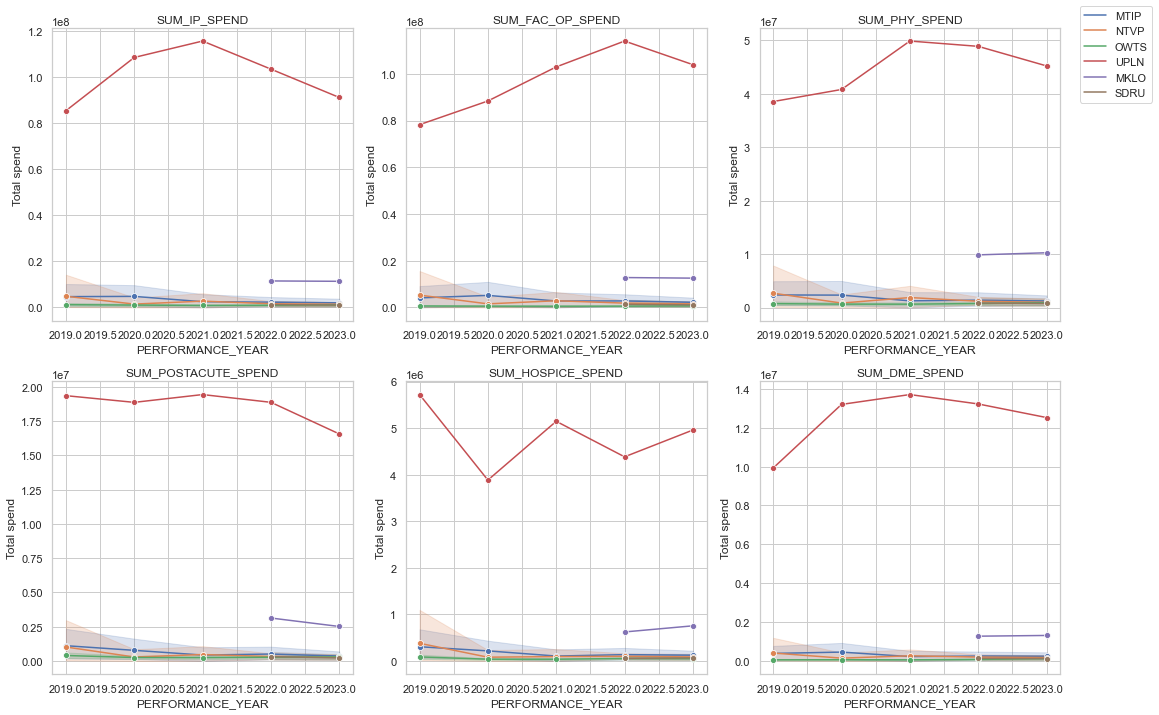

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=False)
legend_labels={}
for index,y_ax in enumerate(y_axis):
    ax = plt.subplot(2,3,index+1)
    sns.lineplot(ax=ax, data=df3,x='PERFORMANCE_YEAR',y=y_ax,hue='QRO',marker='o')
    plt.title(y_ax)
    plt.ylabel('Total spend')
    handles, labels = ax.get_legend_handles_labels()
    legend_labels[y_ax] = (handles, labels)
for ax in fig.axes:
    ax.get_legend().remove()
fig.legend(*legend_labels[y_axis[-1]], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

#### TIN_Q10-13_Event_Rate


In [24]:
df4.head(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE
0,2019,MTIP,183834,797.1,0.758,307.5,0.139
1,2019,MTIP,834843,688.6,0.696,230.1,0.094
2,2019,MTIP,122406,166.7,1.000,NaN,NaN
3,2019,MTIP,125904,1062.5,0.735,218.8,NaN
4,2019,MTIP,496926,1004.5,0.779,354.0,0.145


In [25]:
df4.columns[3:]

Index(['ED_VISIT_RATE', 'ED_RETURN_72HRS', 'IP_ADMIT_RATE',
       'READMIT_30DAY_RATE'],
      dtype='object')

In [26]:
df4.fillna(0,inplace=True)

In [27]:
metrics = ['ED_VISIT_RATE', 'ED_RETURN_72HRS', 'IP_ADMIT_RATE', 'READMIT_30DAY_RATE']
df4_melted = df4.melt(id_vars=['QRO'], value_vars=metrics, var_name='Metric', value_name='Rate')
df4_melted

,QRO,Metric,Rate
0,MTIP,ED_VISIT_RATE,797.100
1,MTIP,ED_VISIT_RATE,688.600
2,MTIP,ED_VISIT_RATE,166.700
3,MTIP,ED_VISIT_RATE,1062.500
4,MTIP,ED_VISIT_RATE,1004.500
...,...,...,...
1251,SDRU,READMIT_30DAY_RATE,0.000
1252,SDRU,READMIT_30DAY_RATE,0.250
1253,SDRU,READMIT_30DAY_RATE,0.000
1254,SDRU,READMIT_30DAY_RATE,0.250


In [28]:
df4_melted[df4_melted.Metric == 'ED_RETURN_72HRS']

,QRO,Metric,Rate
314,MTIP,ED_RETURN_72HRS,0.758
315,MTIP,ED_RETURN_72HRS,0.696
316,MTIP,ED_RETURN_72HRS,1.000
317,MTIP,ED_RETURN_72HRS,0.735
318,MTIP,ED_RETURN_72HRS,0.779
...,...,...,...
623,SDRU,ED_RETURN_72HRS,0.000
624,SDRU,ED_RETURN_72HRS,0.318
625,SDRU,ED_RETURN_72HRS,0.000
626,SDRU,ED_RETURN_72HRS,0.511


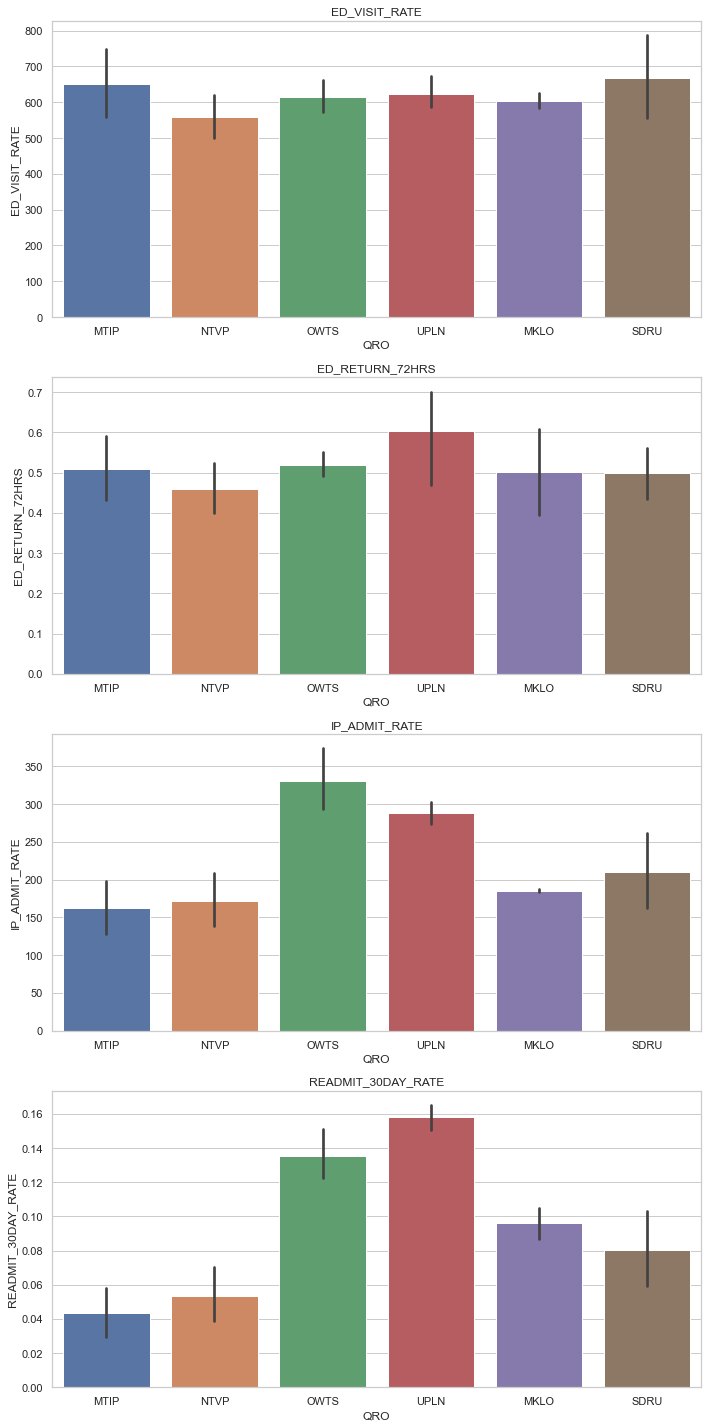

In [29]:
# plt.figure(figsize=(14,8))
# sns.barplot(data=df4_melted,x='Metric',y='Rate',hue='QRO')
# plt.show()
fig,axes = plt.subplots(len(metrics),1,figsize=(10,20))
for index,metric in enumerate(metrics):
    sns.barplot(ax=axes[index],x='QRO', y=metric, data=df4)
    axes[index].set_title(metric)
plt.tight_layout()
plt.show()

#### TIN_VISIT_Q8-14

In [30]:
df5.sample(5)

,PERFORMANCE_YEAR,QRO,TIN_CCN,AWV_RATE,SUM_PCP_VISITS,CNT_PCP_VISITS,SUM_SPEC_VISITS,CNT_SPEC_VISITS
179,2022,OWTS,230982,0.293,95911.31,1518,47098.10,623
51,2020,NTVP,658471,0.074,10169.09,130,5441.33,94
35,2019,OWTS,864941,0.786,33277.97,364,35206.30,523
226,2022,SDRU,277900,0.290,625044.50,4787,162445.28,2124
294,2023,OWTS,355426,0.508,194475.82,2653,255286.26,3247


In [31]:
df5.isnull().sum()

PERFORMANCE_YEAR    0
QRO                 0
TIN_CCN             0
AWV_RATE            0
SUM_PCP_VISITS      0
CNT_PCP_VISITS      0
SUM_SPEC_VISITS     0
CNT_SPEC_VISITS     0
dtype: int64

In [32]:
df5['AVG_PCP_VISIT'] = df5['SUM_PCP_VISITS'] / df5['CNT_PCP_VISITS']
df5['AVG_SPEC_VISIT'] = df5['SUM_SPEC_VISITS'] / df5['CNT_SPEC_VISITS']
df5_AVG = df5[['QRO','AVG_PCP_VISIT','AVG_SPEC_VISIT']]
df5_AVG


,QRO,AVG_PCP_VISIT,AVG_SPEC_VISIT
0,MTIP,98.859000,38.346667
1,MTIP,122.300000,NaN
2,MTIP,8.790000,NaN
3,MTIP,NaN,NaN
4,MTIP,103.826808,60.129935
...,...,...,...
347,SDRU,73.203802,72.891298
348,SDRU,80.700000,75.209394
349,SDRU,68.393713,72.628817
350,SDRU,77.962321,80.745161


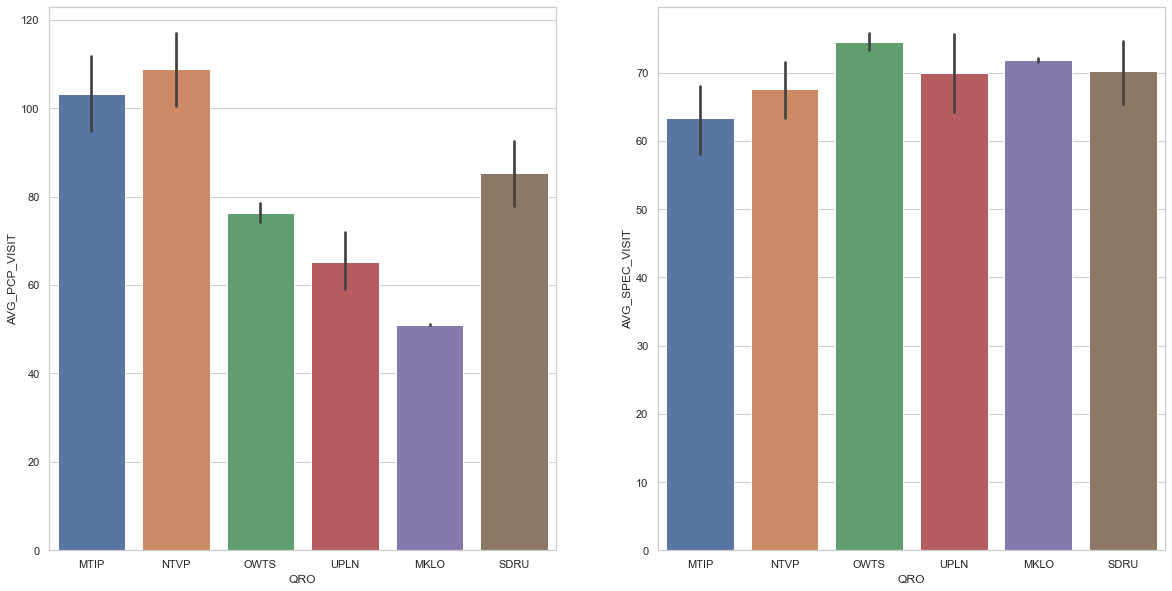

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(data=df5_AVG,x='QRO',y='AVG_PCP_VISIT')
plt.subplot(1,2,2)
sns.barplot(data=df5_AVG,x='QRO',y='AVG_SPEC_VISIT')
plt.show()

## Create composite score


### Normalize the metrics
#### Cost Efficiency (CE)


In [34]:
df2['TOTAL_SPEND_NORMALIZED'] = (df2['TOTAL_SPEND'] - df2['TOTAL_SPEND'].min()) / (df2['TOTAL_SPEND'].max() - df2['TOTAL_SPEND'].min())
df2.head(10)

,PERFORMANCE_YEAR,QRO,TIN_CCN,TOTAL_SPEND,AGED_TOTAL_SPEND,DISABLED_TOTAL_SPEND,ESRD_TOTAL_ESRD,AGED_DUAL_TOTAL_SPEND,TOTAL_SPEND_NORMALIZED
0,2019,MTIP,122406,18332.78,1755.58,16577.20,0.00,0.00,5.891776e-05
1,2019,MTIP,679036,122.30,122.30,0.00,0.00,0.00,3.930469e-07
2,2019,MTIP,344888,8.79,0.00,0.00,8.79,0.00,2.824924e-08
3,2019,MTIP,125904,326079.83,165138.70,61145.21,99795.92,0.00,1.047953e-03
4,2019,MTIP,183834,51693176.93,36549230.25,7356027.20,3118860.85,4668087.62,1.661312e-01
5,2019,MTIP,496926,23839256.13,13611249.27,4249489.28,2781353.80,3197163.78,7.661443e-02
6,2019,MTIP,834843,15403252.31,9968983.63,3492489.05,531538.09,1410241.54,4.950286e-02
7,2019,NTVP,781599,417667.13,224500.66,49167.75,0.00,143998.72,1.342296e-03
8,2019,NTVP,592226,593702.46,298825.48,73632.90,183604.05,37640.03,1.908037e-03
9,2019,NTVP,604033,43165389.11,29258932.13,7510381.24,2142818.04,4253257.70,1.387246e-01


In [35]:
df3['TOTAL_SPEND'] = df3["SUM_IP_SPEND"] + df3["SUM_FAC_OP_SPEND"] + df3["SUM_PHY_SPEND"] + df3["SUM_POSTACUTE_SPEND"] + df3["SUM_HOSPICE_SPEND"] + df3["SUM_DME_SPEND"]
df3['TOTAL_SPEND_NORMALIZED'] = (df3['TOTAL_SPEND'] - df3['TOTAL_SPEND'].min()) / (df3['TOTAL_SPEND'].max() - df3['TOTAL_SPEND'].min())
df3.head(10)

,PERFORMANCE_YEAR,QRO,TIN_CCN,SUM_IP_SPEND,SUM_FAC_OP_SPEND,SUM_PHY_SPEND,SUM_POSTACUTE_SPEND,SUM_HOSPICE_SPEND,SUM_DME_SPEND,TOTAL_SPEND,TOTAL_SPEND_NORMALIZED
0,2019,MTIP,183834,19192504.70,16020228.69,9062788.08,4477877.38,1320060.30,1349982.92,51423442.07,1.676181e-01
1,2019,MTIP,834843,5364179.15,4602899.62,3152931.99,1253099.57,433572.46,548635.03,15355317.82,5.005166e-02
2,2019,MTIP,122406,0.00,11329.40,7003.38,0.00,0.00,0.00,18332.78,5.975689e-05
3,2019,MTIP,344888,0.00,8.79,0.00,0.00,0.00,0.00,8.79,2.865158e-08
4,2019,MTIP,125904,48225.71,134299.70,101493.16,12408.65,0.00,25392.39,321819.61,1.048992e-03
5,2019,MTIP,679036,0.00,122.30,0.00,0.00,0.00,0.00,122.30,3.986448e-07
6,2019,MTIP,496926,8349692.58,7973268.19,4120389.79,2062108.87,386510.00,809313.60,23701283.03,7.725588e-02
7,2019,NTVP,604033,14219144.68,15605275.94,7850739.14,2978073.88,1096923.82,1191230.15,42941387.61,1.399703e-01
8,2019,NTVP,592226,204133.09,205026.42,100282.72,42342.66,18145.17,20507.22,590437.28,1.924569e-03
9,2019,NTVP,781599,173285.78,77484.92,82410.87,38663.52,24292.54,20873.07,417010.70,1.359274e-03


#### Visit Rate Effectiveness (VRE)

In [36]:
df4['VISIT_RATE_EFFECTIVENESS'] = 0.75 * (1 - df4['ED_RETURN_72HRS']) + 0.25 * (1 - df4['READMIT_30DAY_RATE'])
df4['EFFECTIVENESS_NORMALIZED'] = (df4['VISIT_RATE_EFFECTIVENESS'] - df4['VISIT_RATE_EFFECTIVENESS'].min()) / (df4['VISIT_RATE_EFFECTIVENESS'].max() - df4['VISIT_RATE_EFFECTIVENESS'].min())
df4

,PERFORMANCE_YEAR,QRO,TIN_CCN,ED_VISIT_RATE,ED_RETURN_72HRS,IP_ADMIT_RATE,READMIT_30DAY_RATE,VISIT_RATE_EFFECTIVENESS,EFFECTIVENESS_NORMALIZED
0,2019,MTIP,183834,797.1,0.758,307.5,0.139,0.39675,0.257538
1,2019,MTIP,834843,688.6,0.696,230.1,0.094,0.45450,0.328615
2,2019,MTIP,122406,166.7,1.000,0.0,0.000,0.25000,0.076923
3,2019,MTIP,125904,1062.5,0.735,218.8,0.000,0.44875,0.321538
4,2019,MTIP,496926,1004.5,0.779,354.0,0.145,0.37950,0.236308
...,...,...,...,...,...,...,...,...,...
309,2023,SDRU,680049,142.9,0.000,47.6,0.000,1.00000,1.000000
310,2023,SDRU,857343,440.0,0.318,160.0,0.250,0.69900,0.629538
311,2023,SDRU,614138,142.9,0.000,0.0,0.000,1.00000,1.000000
312,2023,SDRU,676890,552.9,0.511,235.3,0.250,0.55425,0.451385


#### Patient Complexity & Outcomes

In [41]:
df1['BENE_CNT'] = df1['BENE_CNT'].replace('<11',5.5).astype(float)

# One-hot encode 'ENROLLMENT_TYPE'
encoder = OneHotEncoder(sparse=False)
encoded_types = encoder.fit_transform(df1[['ENROLLMENT_TYPE']])
encoded_type_df = pd.DataFrame(encoded_types,columns=encoder.get_feature_names_out())

# Normalize 'BENE_CNT' and 'AVR_RISK_SCORE'
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(df1[['BENE_CNT','AVR_RISK_SCORE']])
normalized_df = pd.DataFrame(normalized_values,columns=['BENE_CNT_NORM','AVR_RISK_SCORE_NORM'])

normalized_matrix = pd.concat([df1[['PERFORMANCE_YEAR','QRO','TIN_CCN']],encoded_type_df,normalized_df],axis=1)
normalized_matrix



/Users/wzyy/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM
0,2019,OWTS,230982,0.0,0.0,0.0,1.0,0.0,0.0,1.000000
1,2023,SDRU,636998,0.0,0.0,1.0,0.0,0.0,0.0,0.856503
2,2023,OWTS,254468,0.0,1.0,0.0,0.0,0.0,0.0,0.832941
3,2022,OWTS,659770,0.0,0.0,0.0,1.0,0.0,0.0,0.763195
4,2020,NTVP,592226,0.0,0.0,0.0,1.0,0.0,0.0,0.739868
...,...,...,...,...,...,...,...,...,...,...
1130,2022,OWTS,355426,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
1131,2022,OWTS,253824,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
1132,2023,OWTS,566158,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
1133,2022,SDRU,636998,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


### Calculate composite score

In [43]:
df_com_score = df3.merge(df4,on=['TIN_CCN','PERFORMANCE_YEAR'])[['PERFORMANCE_YEAR','TIN_CCN','TOTAL_SPEND_NORMALIZED','EFFECTIVENESS_NORMALIZED']]
df_com_score['Composite_Score'] = 0.5* df_com_score['TOTAL_SPEND_NORMALIZED'] + 0.5 * df_com_score['EFFECTIVENESS_NORMALIZED']
# df_com_score['Cost_Visit_Ratio'] = df_com_score['TOTAL_SPEND_NORMALIZED']/df_com_score['CNT_VISITS_NORMALIZED']
df_com_score = normalized_matrix.merge(df_com_score,on=['TIN_CCN','PERFORMANCE_YEAR'])
df_com_score

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM,TOTAL_SPEND_NORMALIZED,EFFECTIVENESS_NORMALIZED,Composite_Score
0,2019,OWTS,230982,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.012368,0.318769,0.165568
1,2019,OWTS,230982,0.0,1.0,0.0,0.0,0.0,0.002441,0.278040,0.012368,0.318769,0.165568
2,2019,OWTS,230982,0.0,0.0,1.0,0.0,0.0,0.001029,0.251178,0.012368,0.318769,0.165568
3,2019,OWTS,230982,1.0,0.0,0.0,0.0,0.0,0.009557,0.243402,0.012368,0.318769,0.165568
4,2023,SDRU,636998,0.0,0.0,1.0,0.0,0.0,0.000000,0.856503,0.000236,0.604000,0.302118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,SDRU,812423,1.0,0.0,0.0,0.0,0.0,0.000000,0.068332,0.000012,1.000000,0.500006
1074,2022,SDRU,812423,0.0,0.0,1.0,0.0,0.0,0.000000,0.060556,0.000012,1.000000,0.500006
1075,2023,NTVP,602055,1.0,0.0,0.0,0.0,0.0,0.000000,0.064562,0.000021,1.000000,0.500010
1076,2023,NTVP,455724,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000116,1.000000,0.500058


### Rank TIN_CCN

In [44]:
df_com_score.sort_values(['Composite_Score'],ascending=False)

,PERFORMANCE_YEAR,QRO,TIN_CCN,ENROLLMENT_TYPE_Aged,ENROLLMENT_TYPE_Aged-Dual,ENROLLMENT_TYPE_Disabled,ENROLLMENT_TYPE_ESRD,ENROLLMENT_TYPE_Unknown,BENE_CNT_NORM,AVR_RISK_SCORE_NORM,TOTAL_SPEND_NORMALIZED,EFFECTIVENESS_NORMALIZED,Composite_Score
143,2023,UPLN,430950,0.0,1.0,0.0,0.0,0.0,0.056430,0.234920,0.894247,0.635385,0.764816
139,2023,UPLN,430950,0.0,0.0,0.0,0.0,1.0,0.001088,0.421065,0.894247,0.635385,0.764816
141,2023,UPLN,430950,0.0,0.0,1.0,0.0,0.0,0.124768,0.297597,0.894247,0.635385,0.764816
140,2023,UPLN,430950,0.0,0.0,0.0,1.0,0.0,0.012850,0.399387,0.894247,0.635385,0.764816
142,2023,UPLN,430950,1.0,0.0,0.0,0.0,0.0,1.000000,0.240811,0.894247,0.635385,0.764816
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022,SDRU,982445,0.0,1.0,0.0,0.0,0.0,0.000000,0.111216,0.000016,0.076923,0.038470
990,2022,SDRU,517316,0.0,0.0,1.0,0.0,0.0,0.000000,0.172950,0.000013,0.076923,0.038468
740,2022,SDRU,636998,0.0,0.0,1.0,0.0,0.0,0.000000,0.248351,0.000126,0.000000,0.000063
741,2022,SDRU,636998,1.0,0.0,0.0,0.0,0.0,0.000000,0.082705,0.000126,0.000000,0.000063


Higher scores indicate better overall performance considering both cost efficiency and visit rate effectiveness.

## Model Evaluation


In [46]:
X = df_com_score.drop(['PERFORMANCE_YEAR', 'QRO', 'TIN_CCN', 'Composite_Score'],axis=1)
y = df_com_score['Composite_Score']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 2.747700585717324e-05
